# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [1]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [2]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [3]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to long name
ktn = kt.loc[:,['KEGG ID(S)', 'PRIMARY NAME']]
ktn['KEGG ID(S)'] = ktn['KEGG ID(S)'].str.lower() # set to lower case for better matching
ktn.set_index('KEGG ID(S)', inplace = True)

# translate long name to KEGG ID
# the original dictionaries sometimes had trouble with duplicate KEGG IDs. If there are duplicates, make sure to choose the lowest number
ntk = kt.loc[:,['PRIMARY NAME', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
ntk['PRIMARY NAME'] = ntk['PRIMARY NAME'].str.lower() # set to lower case for better matching
ntk = ntk.groupby('PRIMARY NAME').first() # take the first KEGG ID in each group

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']]
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk.set_index('ABBREVIATION', inplace = True)

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))
ktaDict = dict(zip(kta.index.str.upper(), kta['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [4]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [5]:
allRxnDf = pd.read_excel('all_ems_and_ham_dist_DO_SD.xlsx', sheet_name = 'EFM_model_input')
allRxnDf[:2]

,Name,FullFormula,AbbreviationFormula,KeggFormula,1,2,3,4,5,6,...,327,328,329,330,331,332,333,334,335,336
0,ATPase1,ATP + H2O <=> ADP + Pi,h2o + atp <=> adp + pi,C00002 + C00001 <=> C00008 + C00009,1,1,4,1,1,5,...,6,5,6,5,5,6,5,5,5,5
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,1,1,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1


In [6]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}
no_EFM=len(allRxnDf.columns)-4 # no of EFMs exckude the colomns with reaction name and descriptions
for f in range(1,no_EFM+1):
    selectedRxnDf[f] = allRxnDf.loc[allRxnDf[f] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', f]]
    selectedRxnDf[f].rename(columns = {f:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent

#selectedRxnDf[227]['flux'] # EFM:227 corresponds to wild-type with 6 ATP generated (2 from ATPase1, 4 from ATPase2)

In [7]:
#Import metabolite bound data from excel file
Met_data = pd.read_excel('cth_thermo_model_DO_SD6.xlsx', sheet_name = 'metabolite_bounds')
Met_data

,KEGG_ID,Name,Concentration:Max,Concentration:Min,Type,GetFromMeasured,Unnamed: 6,max (µM),min (µM)
0,C00008,adp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
1,C00020,amp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
2,C00002,atp,0.02000,0.001000,Cofactor,no,NaN,20000.0,1000.0
3,C00010,coa,0.02000,0.000001,Cofactor,no,NaN,20000.0,1.0
4,C00139,fdxox,0.00010,0.000100,Cofactor,NaN,NaN,100.0,100.0
5,C00138,fdxrd,0.01000,0.000001,Cofactor,NaN,NaN,10000.0,1.0
6,C00035,gdp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
7,C00044,gtp,0.02000,0.001000,Cofactor,no,NaN,20000.0,1000.0
8,C00003,nad,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
9,C00004,nadh,0.01000,0.000001,Cofactor,no,NaN,10000.0,1.0


In [8]:
Uf = 1 # Uncertainity factor
all_data={}
for f in range(1,no_EFM+1):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    all_data[f] = {}
    
    #impose default concentration bounds read from excel file
    for i, cpd in Met_data.iterrows():
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
           
    # calculate the min-max driving force
    mdf_data, con = pp.conc_mdf()
    #mdf_data.mdf_plot
    # store the data
    all_data[f]['mdf'] = mdf_data
    all_data[f]['con'] = con

In [9]:
import matplotlib.pyplot as plt
all_mdf={}
for f in range(1,no_EFM+1):
    all_mdf[f]=float(all_data[f]['mdf'].mdf)
df1 = pd.DataFrame.from_dict(list(all_mdf.items()))    
all_atp={}   
for f in range(1,no_EFM+1):
    try:
        all_atp[f]=selectedRxnDf[f]['flux'][0]+selectedRxnDf[f]['flux'][36]-1 # assuming all ATP generated are being consumed by ATPase 1 (index=0) and 2(index=36)
    except:
        try:
            all_atp[f]=selectedRxnDf[f]['flux'][0]-1
        except:
            try:
                all_atp[f]=selectedRxnDf[f]['flux'][36]-1
            except:
                all_atp[f]=0
                print(f)
            
df2 = pd.DataFrame.from_dict(list(all_atp.items()))         

#plt.scatter(df1[1],df2[1])
#plt.xlabel('MDF of flux set')
#plt.ylabel('ATP generated by fluxset')
#plt.title('MDF vs ATP generated')

In [10]:
#Hamming distance calculation
df=pd.DataFrame(index=np.arange(1, no_EFM),columns=('Pathway mdf', 'ATP generated', 'old Hamming distance'))
ham_dis={}
wt_ind=227
for f in range(1,no_EFM+1):
    inx=0
    ham_dis[f]=0

    for i in allRxnDf[[f]][f]:
        #calculating hamming distance by counting the unique reactions in the larger EFM 
        if not ((i == 0 and allRxnDf[[wt_ind]][wt_ind][inx] == 0) or (abs(i)>0 and abs(allRxnDf[[wt_ind]][wt_ind][inx])>0)):
            if len(selectedRxnDf[inx+1])>len(selectedRxnDf[wt_ind]):
                ham_dis[f]+=np.sign(abs(i))
            else:
                ham_dis[f]+=np.sign(abs(allRxnDf[[wt_ind]][wt_ind][inx]))
        inx+=1
    df.loc[f]=[df1[1][f-1],df2[1][f-1],ham_dis[f]]

In [11]:
#Updated Hamming distance calculation
import math as mt
df=pd.DataFrame(index=np.arange(1, no_EFM),columns=('Pathway MDF', 'ATP generated', 'No. of modifications'))
df_cl3=pd.DataFrame(index=np.arange(1, no_EFM),columns=('Pathway MDF', 'ATP generated', 'No. of modifications'))

ham_dis={}
wt_ind=227
inx=0
for f in range(1,no_EFM+1):
    ham_dis[f]=0
    for i,row in allRxnDf.iterrows():
        if allRxnDf.loc[i,'Name'] not in ['ATPase1','ATPase2','GLK-GTP','GLK-ATP','PGK-ATP','PGK-GTP','MDH','ME','RNF_ATPase','RNF_PPiase','NDK','Gly-cyc','NFN']:
            if allRxnDf.loc[i,f]!=allRxnDf.loc[i,227]:
                ham_dis[f]+=np.sign(abs(allRxnDf.loc[i,227]))
            if allRxnDf.loc[i,'Name'] in ['NADPH-FNOR','NADH-FNOR']: #if either FNOR is present then it has replaced RNFs and should increase hamming distance
                ham_dis[f]+=np.sign(abs(allRxnDf.loc[i,f]))
    df.loc[f]=[df1[1][f-1],df2[1][f-1],ham_dis[f]]
    if df1[1][f-1]>2 and df1[1][f-1]<5:
        df_cl3.loc[inx]=[df1[1][f-1],df2[1][f-1],mt.floor(ham_dis[f])] 
        inx+=1
#df_cl3.drop(index=range(inx,no_EFM))

In [12]:
#Testing hamming distance
for f in range(182,183):
    inx=0
    ham_dis[f]=0
    for i,row in allRxnDf.iterrows():
        if allRxnDf.loc[i,'Name'] not in ['ATPase1','GLK-GTP','GLK-ATP','PGK-ATP','PGK-GTP','MDH','ME','RNF_ATPase','RNF_PPiase','NDK','Gly-cyc','NFN']:
            if allRxnDf.loc[i,f]!=allRxnDf.loc[i,227]:
                ham_dis[f]+=np.sign(abs(allRxnDf.loc[i,227]))
                print(allRxnDf.loc[i,'Name'],ham_dis[f])
            if allRxnDf.loc[i,'Name'] in ['NADPH-FNOR','NADH-FNOR']: #if either FNOR is present then it has replaced RNFs and should increase hamming distance
                ham_dis[f]+=np.sign(abs(allRxnDf.loc[i,f]))
                print(allRxnDf.loc[i,'Name'],ham_dis[f])
                                    

PFK-PPi 1
PFK-ATP 1
ADH-NADH 2
ADH-NADPH 2
NADPH-FNOR 2
NADPH-FNOR 3
NADH-FNOR 3


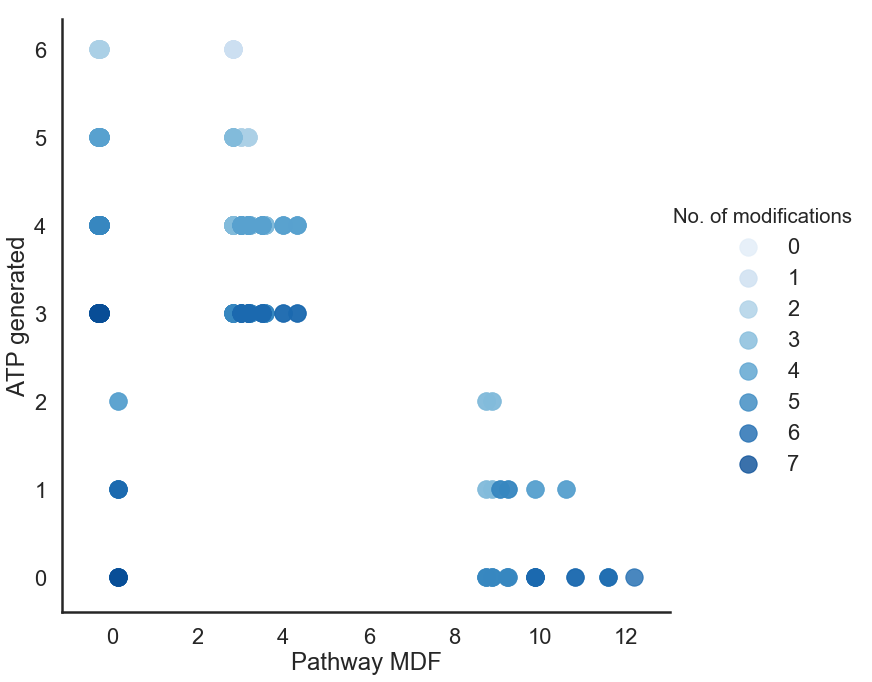

In [110]:
#max(ham_dis)
import seaborn as sns
color = [str((item*10)/(max(ham_dis)*10)) for item in ham_dis]


#ax.scatter(df1[1],df2[1],c=color,s=300, marker='o', edgecolors='black')



#plt.xlabel('MDF of flux set')
#plt.ylabel('ATP generated by fluxset')
#plt.title('MDF vs ATP generated')
# library & dataset
#df3 = pd.DataFrame.from_dict(list(ham_dis.items()))   

#df=pd.merge(df1,df2,0.df1,0.df2)
# Use the 'hue' argument to provide a factor variable
sns.set_context("poster")
sns.set_style("white")
sns_plot=sns.lmplot( x='Pathway MDF', y='ATP generated', data= df ,fit_reg=False, hue='No. of modifications', palette="Blues", legend=True, height=10, markers='o',scatter_kws={"s": 300})
sns_plot.savefig("mdfvsatp.png")

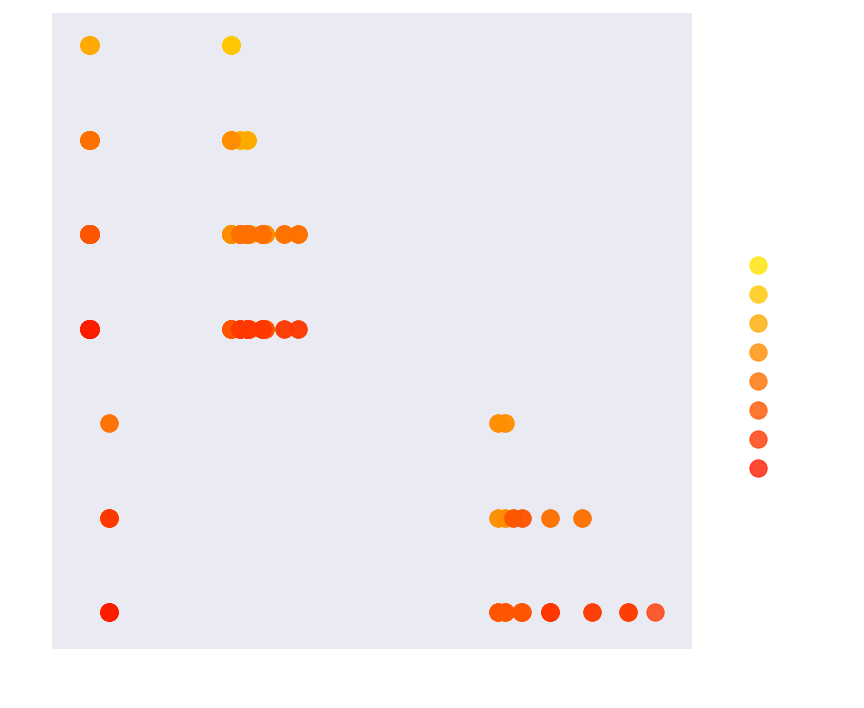

In [131]:

# Use the 'hue' argument to provide a factor variable
sns.set_context("poster")
#sns.set_style("white")
#'axes.facecolor':'black','figure.facecolor':'black',
sns.set(rc={'axes.labelcolor':'white','grid.color':'none','text.color':'white','xtick.color':'white','ytick.color':'white','ytick.labelsize':20,'legend.fontsize':20,'xtick.labelsize':20,'axes.labelsize':20})
sns_plot=sns.lmplot( x='Pathway MDF', y='ATP generated', data= df ,fit_reg=False, hue='No. of modifications', palette="autumn_r", legend=True, height=10, markers='o',scatter_kws={"s": 300})
sns_plot.savefig("mdfvsatp_autumn.png",transparent=True)

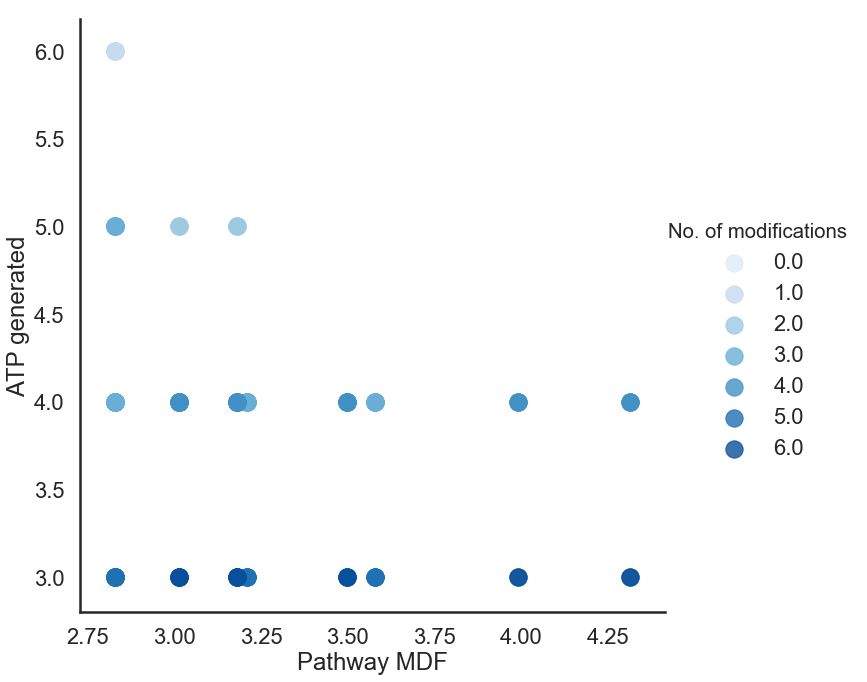

In [127]:
#df_cl3 = df_cl3.astype({'Pathway MDF':'float64', 'ATP generated':'float64', 'No. of modifications':'int64'})

sns.set_context("poster")
sns.set_style("white")
ax=sns_plot=sns.lmplot( x='Pathway MDF', y='ATP generated', data= df_cl3 ,fit_reg=False, hue='No. of modifications', palette="Blues", legend=True, height=10, markers='o',scatter_kws={"s": 300})
sns_plot.savefig("mdfvsatp_cluster3.png")
#ax.add_legend(label_order = sorted(ax._legend_data.keys(), key = round))


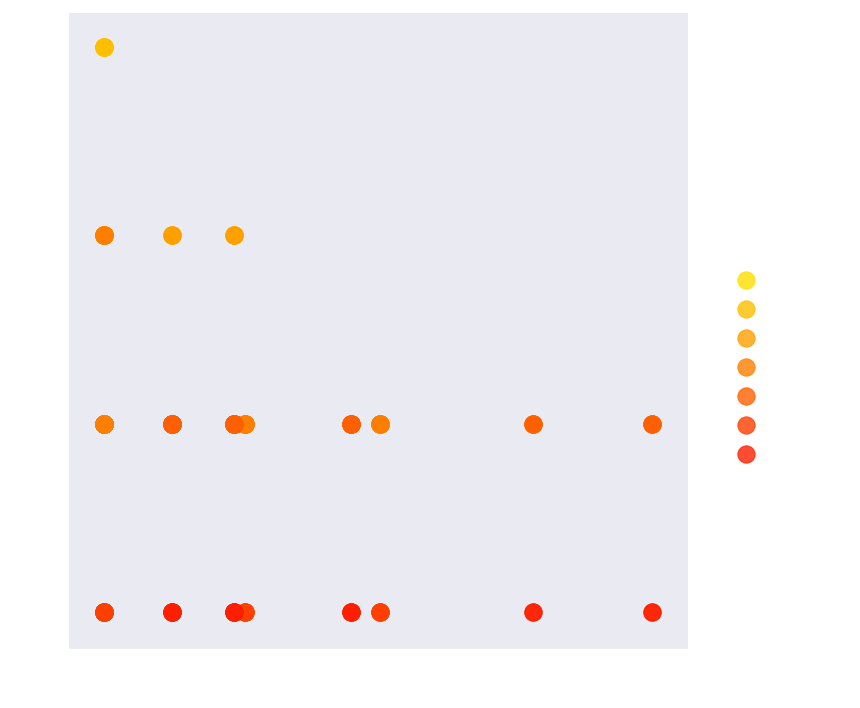

In [134]:
#df_cl3 = df_cl3.astype({'Pathway MDF':'float64', 'ATP generated':'float64', 'No. of modifications':'int64'})
#sns.set_context("poster")
sns.set(rc={'axes.labelcolor':'white','grid.color':'none','text.color':'white','xtick.color':'white','ytick.color':'white','ytick.labelsize':20,'legend.fontsize':20,'xtick.labelsize':20,'axes.labelsize':20})
ax=sns_plot=sns.lmplot( x='Pathway MDF', y='ATP generated', data= df_cl3 ,fit_reg=False, hue='No. of modifications', palette="autumn_r", legend=True, height=10, markers='o',scatter_kws={"s": 300})
sns_plot.savefig('mdfvsatp_cluster3_autumn.png',transparent=True)
#ax.add_legend(label_order = sorted(ax._legend_data.keys(), key = round))


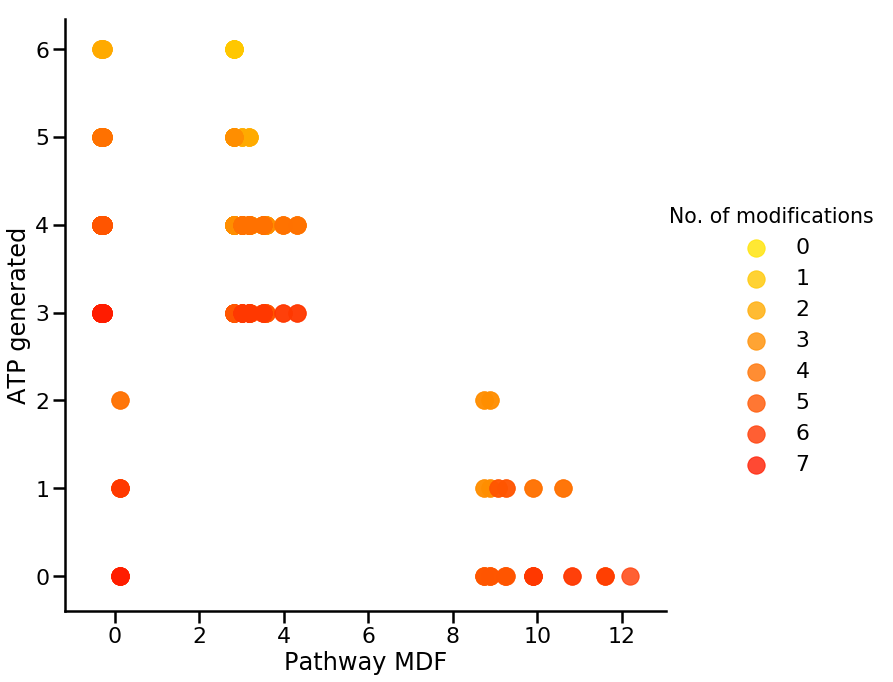

In [31]:

sns.set_context("poster")
sns_plot=sns.lmplot( x='Pathway MDF', y='ATP generated', data= df ,fit_reg=False, hue='No. of modifications', palette="autumn_r", legend=True, height=10, markers='o',scatter_kws={"s": 300})
sns_plot.savefig("mdfvsatp_autumn.png")

In [75]:
#write the mdf, updated hamming distance, and atp generated into a csv file
import csv
w = csv.writer(open("output_v4.csv", "w"))
for key, val in all_mdf.items():
    w.writerow([key, val,all_atp[key],ham_dis[key]])
all_data[1]['con'].items()   
w = csv.writer(open("output_conc_v4.csv", "w"))
for f in range(1,no_EFM+1):
    k=0
    for c in all_data[f]['mdf'].compound_data:
        w.writerow([f,ktaDict[c.compound], all_data[f]['con'][k]])
        k=k+1
    w.writerow(" ")

In [15]:
#Evaluate WILD-type EFM
chk_data={}
for f in range(227,228):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    chk_data[f] = {}
    
    #impose default concentration bounds read from excel file
    for i, cpd in Met_data.iterrows():
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
        #print(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'])
        #pp.bounds.SetBounds(cpd['KEGG_ID'],1e-6,1e-2 )
    #pp.bounds.SetBounds('C00469',1e-6,1e-2)      
    # calculate the min-max driving force
    mdf_data, con = pp.conc_mdf()
    #mdf_data.mdf_plot
    # store the data
    chk_data[f]['mdf'] = mdf_data
    chk_data[f]['con'] = con
for r in mdf_data.reaction_data:
    print(r.reaction.reaction_id, float(r.dGr))

ATPase1 -43.507631032369446
CBP -2.8291089397399487
GLK-GTP -20.492743350376244
PGMT -2.8291089397399523
PGI -2.8291089397399496
PFK-PPi -2.829108939739945
FBA -2.8291089397399602
TPI -2.8291089397399496
GAPDH -2.829108939739948
PGK-GTP -2.8291089397399602
PGM -2.829108939739947
ENO -2.829108939739956
PPDK -2.8291089397399567
PFOR -2.8291089397399496
RNF_PPiase -16.289175355601174
ALDH-NADH -2.829108939739946
ADH-NADH -2.8291089397399425
NDK -2.8291089397399496
ATPase2 -49.846639160809104


In [16]:
k=0
print(chk_data[227]['mdf'].mdf)
for c in all_data[227]['mdf'].compound_data:
        print([f,ktaDict[c.compound], chk_data[227]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),chk_data[227]['con'][k], c.shadow_price])
        k=k+1

2.8291089397399496
[227, 'h2o', (1.0, 1.0), (1.0, 1.0), -3.5191975120193643e-16]
[227, 'atp', (0.001, 0.02), (0.0010000000000000037, 0.001016941199644367), 0.0]
[227, 'nad', (0.0001, 0.0001), (9.999999999999991e-05, 9.999999999999991e-05), 0.0]
[227, 'nadh', (1e-06, 0.01), (2.4780095370124336e-06, 2.4780095370124467e-06), 0.0]
[227, 'adp', (0.0001, 0.0001), (9.999999999999991e-05, 9.999999999999991e-05), -1.6950726536687657e-16]
[227, 'pi', (0.01, 0.01), (0.010000000000000004, 0.010000000000000004), 0.3097033125000002]
[227, 'coa', (1e-06, 0.02), (1.0000000000000004e-06, 8.270971879591337e-06), 0.0]
[227, 'co2', (1e-05, 1e-05), (9.999999999999997e-06, 9.999999999999997e-06), 0.0]
[227, 'ppi', (1e-06, 0.02), (0.01999999999999994, 0.020000000000000056), 0.3097033125000003]
[227, 'amp', (0.0001, 0.0001), (0.00010000000000000009, 0.00010000000000000009), 1.6950726536687657e-16]
[227, 'pyr', (1e-06, 0.02), (1.2963523068168421e-06, 0.0002965452695374629), 0.0]
[227, 'accoa', (1e-06, 0.02), (

In [14]:
#Evaluate the malate shunt EFM with ADH-NADPH (254 or 325) vs CO2
chk_data={}
ratio=np.geomspace(1e-5, 6e-2, num=30)
for f in [227,254]:
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    chk_data[f] = {}
    
    #impose default concentration bounds read from excel file
    for i, cpd in Met_data.iterrows():
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
        #print(ktaDict[cpd['KEGG_ID']],cpd['Concentration:Min'],cpd['Concentration:Max'])
        #pp.bounds.SetBounds(cpd['KEGG_ID'],1e-6,1e-2 )
    pp.bounds.SetBounds('C00036',1e-6,1e-2)
    #pp.bounds.SetBounds('C00469',1e-6,1e-1)
    for co2 in ratio: 
        pp.bounds.SetBounds('C00011',1e-5,co2)
        chk_data[f][co2]={}
        # calculate the min-max driving force
        mdf_data, con = pp.conc_mdf()
        #mdf_data.mdf_plot
        # store the data
        chk_data[f][co2]['mdf'] = mdf_data
        chk_data[f][co2]['con'] = con
'''        print (co2,mdf_data.mdf)

for r in mdf_data.reaction_data:
    print(r.reaction.reaction_id, float(r.dGr))

k=0
for c in all_data[254]['mdf'].compound_data:
        print([ktaDict[c.compound], chk_data[254][co2]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),chk_data[254][co2]['con'][k], c.shadow_price])
        k=k+1
        '''

"        print (co2,mdf_data.mdf)\n\nfor r in mdf_data.reaction_data:\n    print(r.reaction.reaction_id, float(r.dGr))\n\nk=0\nfor c in all_data[254]['mdf'].compound_data:\n        print([ktaDict[c.compound], chk_data[254][co2]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),chk_data[254][co2]['con'][k], c.shadow_price])\n        k=k+1\n        "

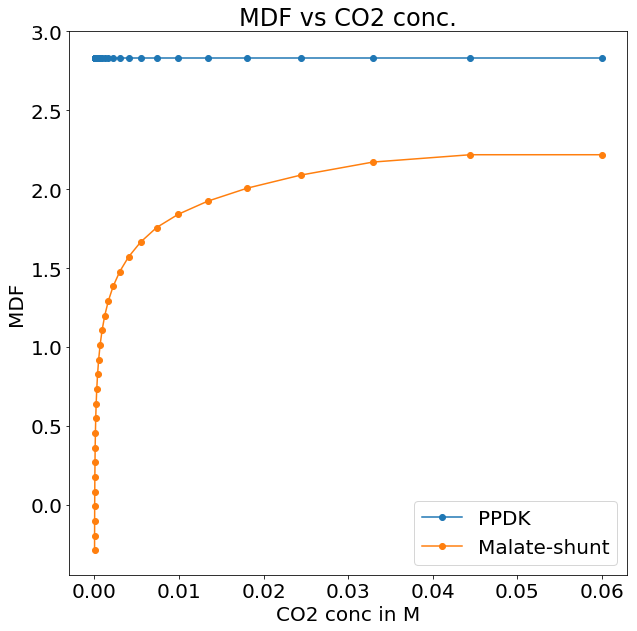

In [15]:
import matplotlib.pyplot as plt

y={}
y[0]={}
y[1]={}
for r in ratio:
    y[0][r] = float(chk_data[227][r]['mdf'].mdf) 
    y[1][r] = float(chk_data[254][r]['mdf'].mdf) 
    #print(r,y[r])
plt.rcParams["figure.figsize"] =[10,10]    
plt.rcParams["font.size"] =20 
df = pd.DataFrame.from_dict(y)

fig=plt.plot(df,'-o')
plt.legend(['PPDK','Malate-shunt'])

plt.yticks(np.arange(0, 3.1, 0.5))
plt.xlabel('CO2 conc in M')
plt.ylabel('MDF')
plt.title('MDF vs CO2 conc.')
plt.savefig("PPDK_vs_mal_snt_vs_co2.png")

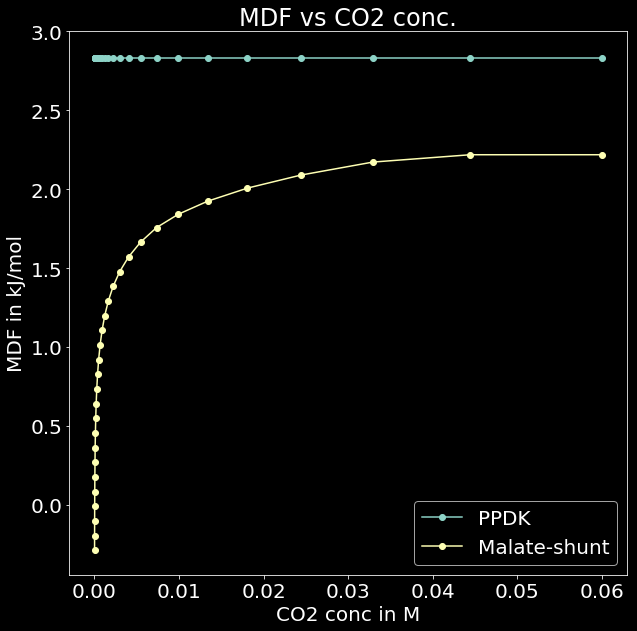

In [25]:
import matplotlib.pyplot as plt

y={}
y[0]={}
y[1]={}
for r in ratio:
    y[0][r] = float(chk_data[227][r]['mdf'].mdf) 
    y[1][r] = float(chk_data[254][r]['mdf'].mdf) 
    #print(r,y[r])
plt.rcParams["figure.figsize"] =[10,10]    
plt.rcParams["font.size"] =20 
plt.style.use(['dark_background'])
plt.rcParams["legend.facecolor"]= 'none'
#plt.rcParams["text.color"] ='white' 
#plt.rcParams["axes.labelcolor"] ='white' 
#plt.rcParams["grid.color"] ='white' 
#plt.rcParams["xtick.color"] ='white' 
#sns.set_style("white")
#sns.set(rc={'axes.labelcolor':'white','grid.color':'none','text.color':'white','xtick.color':'white','ytick.color':'white','ytick.labelsize':20,'legend.fontsize':20,'xtick.labelsize':20,'axes.labelsize':20})

df = pd.DataFrame.from_dict(y)

fig=plt.plot(df,'-o')
plt.legend(['PPDK','Malate-shunt'])

plt.yticks(np.arange(0, 3.1, 0.5))
plt.xlabel('CO2 conc in M')
plt.ylabel('MDF in kJ/mol')
plt.title('MDF vs CO2 conc.')
plt.savefig("PPDK_vs_mal_snt_vs_co2_blue.png",transparent=True)

In [16]:
#Evaluate the malate shunt EFM with ADH-NADPH (254 or 325) vs OAA
chk_data={}
ratio=np.geomspace(1e-7, 1e-5, num=20)
for f in range(254,255):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    chk_data[f] = {}
    
    #impose default concentration bounds read from excel file
    for i, cpd in Met_data.iterrows():
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
        #print(ktaDict[cpd['KEGG_ID']],cpd['Concentration:Min'],cpd['Concentration:Max'])
        #pp.bounds.SetBounds(cpd['KEGG_ID'],1e-6,1e-2 )
    pp.bounds.SetBounds('C00011',1e-5,1e-5)
    for oaa in ratio: 
        pp.bounds.SetBounds('C00036',oaa,1e-2)
        chk_data[f][oaa]={}
        # calculate the min-max driving force
        mdf_data, con = pp.conc_mdf()
        #mdf_data.mdf_plot
        # store the data
        chk_data[f][oaa]['mdf'] = mdf_data
        chk_data[f][oaa]['con'] = con
'''        print (co2,mdf_data.mdf)

for r in mdf_data.reaction_data:
    print(r.reaction.reaction_id, float(r.dGr))

k=0
for c in all_data[254]['mdf'].compound_data:
        print([ktaDict[c.compound], chk_data[254][co2]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),chk_data[254][co2]['con'][k], c.shadow_price])
        k=k+1
        '''

"        print (co2,mdf_data.mdf)\n\nfor r in mdf_data.reaction_data:\n    print(r.reaction.reaction_id, float(r.dGr))\n\nk=0\nfor c in all_data[254]['mdf'].compound_data:\n        print([ktaDict[c.compound], chk_data[254][co2]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound),chk_data[254][co2]['con'][k], c.shadow_price])\n        k=k+1\n        "

Text(0.5, 1.0, 'MDF vs OAA conc.')

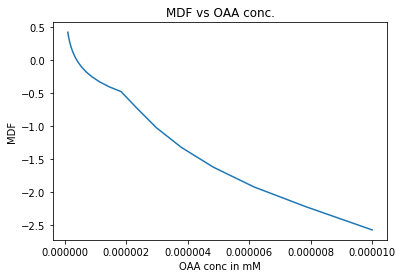

In [17]:
y={}
for r in ratio:
    y[r] = float(chk_data[254][r]['mdf'].mdf) 
plt.plot(*zip(*sorted(y.items())))
plt.xlabel('OAA conc in mM')
plt.ylabel('MDF')
plt.title('MDF vs OAA conc.')